This notebook is based on: 
    Flexural behavior of externally prestressed beams Part 1: Analytical models"
    Chee Khoon Ng, Kiang Hwee Tan. (2006)

Variables that aren't realistic, but are used for testing purposes are:

fc′ :concrete compressive strength (MPa)\
fpe :effective post tensioning stress (MPa) 

Distance from the support to loading point (Ls) and deviator (Ld) also changed by < 1 cm, so it was neglected. 

Setup

In [2]:
using ProgressBars
using Plots
using CSV
using DataFrames
using UnPack

Inputs\
..........Notes..........\
Use Ld = Ls (this test only) \
Eccentricities measured from the neutral axis\
M is the moment in the constant region\
Mg = moment due to the selfweight\
M(x) is the moment equation due to the load\
Units N, mm, MPa

In [6]:
# Material Properties
struct Material
    fc′::Float64 # Concrete strength [MPa] ****Should update on the test day using cylinder test***
    Ec::Float64 # MPa  ACI fc-> Concrete modulus relationship [MPa]
    Eps::Float64 #Post tensioning steel modulus [MPa]
    fpy::Float64 #MPa  
    #Safe load on the website https://www.engineeringtoolbox.com/wire-rope-strength-d_1518.html 
    # is ~ 150 MPa. Currently 140 MPa :)
end

@show fc′= 60. #(*) Concrete strength [MPa] ****Should update on the test day using cylinder test***
@show Ec = 4700.0*sqrt(fc′) # MPa  ACI fc-> Concrete modulus relationship [MPa]
@show Eps = 70000.0 #Post tensioning steel modulus [MPa]
@show fpy = 0.002*Eps #MPa  
#Safe load on the website https://www.engineeringtoolbox.com/wire-rope-strength-d_1518.html 
# is ~ 150 MPa. Currently 140 MPa :)

struct Section
    em::Float64 # Eccentricity at the middle of the member [mm]
    es::Float64 # Eccentricity at the support of the member   [mm]
    em0::Float64 # Initial eccentricity at the midspan        [mm]
    Ls::Float64 # Distance from support to the first load point [mm]
    Ld::Float64 # Distance from support to the first deviator [mm]
    L::Float64 # Total length of the member [mm]
    # two 1/4" bars with 1200 lb capacity
    Aps::Float64 # Total area of the steel in the section [mm^2]
    Atr::Float64 # Transformed area of the cross section [mm^2]
    Itr::Float64 # Moment of inertia of the transformed cross section [mm^4]
    Zb::Float64 # Section modulus of the concrete section from the centroid to extreme tension fiber [mm^3]
end

# PixelFrame section/element properties
# Eccentricity is measured from the centroid of the concrete crossection to the centroid of the steels
@show em = 230.0 # Eccentricity at the middle of the member [mm]
# Since the ropes at the supports are at the centroid of the concrete section
@show es = 0.0    # Eccentricity at the support of the member[mm]
@show em0 = em   # Initial eccentricity at the midspan      [mm]
@show Ls = 502.7 # Distance from support to the first load point [mm]
@show Ld = Ls    # Distance from support to the first deviator [mm]
@show L = 2000.0 # Total length of the member [mm]

# Steel properties
    # two 1/4" bars with 1200 lb capacity
@show Aps = 2.0*(0.25*25.4)^2*pi/4.0 # Total area of the post tensioned steel [mm2]
# If there are multiple materials, transformed section geometry is needed for Zb (and everything related to section area)

@show Atr = 18537.69 + 347.96  # Transformed area of the cross section (Concrete + Steel) [mm2]

# v -> possible error.
#previous value : 8.9795e7
@show Itr  = 1.0788e8  # Moment of inertia of the transformed cross section [mm4]
# # Section modulus of the concrete section from the centroid to extreme tension fiber [mm3]
@show c = 225.0 # Distance from the centroid of the entire section to the centroid of the steel section (extreme tension) [mm]
@show Zb = Itr/c

# Its was = 6.4198e+07 #moment of inertia [mm4]
# Zb  was = 452894.24

struct Loads
    w::Float64 # Selfweight [N/mm]
    mg::Float64 # Moment due to selfweight [Nmm]
    fr::Float64 # Concrete cracking strenght [MPa]
    r::Float64 # Radius of gyration [mm]
    #ps_force::Float64 # Post tensioning force [N]
    fpe::Float64 # Effective post tensioning stress [MPa]
end

# Apply loads
# assume concrete density = 2400 kg/m3
@show w = Atr/10^9*2400.0*9.81 # Selfweight [N/mm]
@show mg = w*L^2/8.0 # Moment due to selfweight [Nmm]
@show fr = 0.7*sqrt(fc′) # Concrete cracking strenght [MPa]
@show r  = sqrt(Itr/Atr) # Radius of gyration [mm]
#@show ps_force = 890 # Post tensioning force [N]

# ***possible error
# we dont know the effective post tensioning stress
@show fpe = 0.0 #ps_force/Aps # Effective post tensioning stress [MPa] ***will input the one on the test day***


fc′ = 60.0 = 60.0
Ec = 4700.0 * sqrt(fc′) = 36406.04345434972
Eps = 70000.0 = 70000.0
fpy = 0.002 * Eps = 140.0
em = 230.0 = 230.0
es = 0.0 = 0.0
em0 = em = 230.0
Ls = 502.7 = 502.7
Ld = Ls = 502.7
L = 2000.0 = 2000.0
Aps = (2.0 * (0.25 * 25.4) ^ 2 * pi) / 4.0 = 63.33843488718721
Atr = 18537.69 + 347.96 = 18885.649999999998
Itr = 1.0788e8 = 1.0788e8
c = 225.0 = 225.0
Zb = Itr / c = 479466.6666666667
w = (Atr / 10 ^ 9) * 2400.0 * 9.81 = 0.4446437436
mg = (w * L ^ 2) / 8.0 = 222321.8718
fr = 0.7 * sqrt(fc′) = 5.422176684690384
r = sqrt(Itr / Atr) = 75.57958457521578
fpe = 0.0 = 0.0


0.0

In [7]:
# Create structs
Mat = Material(fc′, Ec, Eps, fpy)
Sec = Section(em, es, em0, Ls, Ld, L, Aps, Atr, Itr, Zb)
f   = Loads(w, mg, fr, r, fpe)

Loads(0.4446437436, 222321.8718, 5.422176684690384, 75.57958457521578, 0.0)

Function definitions
[In the same order as in the paper]


In [8]:
"""
(2)
"""
function getFps(Mat::Material, Sec::Section, f::Loads, Ω::Float64, M::Float64, e::Float64)

    @unpack fc′, Ec, Eps, fpy = Mat
    @unpack Aps, Atr, Itr, Zb = Sec
    @unpack r, fpe = f

    A = (Ω*M*e) # [A]bove term 
    B = (Itr*Ec/Eps + Aps*(r^2+e^2)*Ω) # [B]elow term
    fps = fpe + A/B
    if fps> fpy 
        fps = fpy
        println("Exceeds the yielding stress-> fps = fpy = $fpy")
    end
    return fps
end

"""
(3) 
Only calculate once
"""
function getMcr(Mat::Material, Sec::Section, f::Loads, Ω::Float64 ) 
    @unpack fc′, Ec, Eps, fpy = Mat
    @unpack Aps, Atr, Itr, Zb, em = Sec
    @unpack w, mg, fr, r, fpe = f

    
    @show mcre = Aps*fpe*(em + Zb/Atr) + (fr * Zb) # Cracking moment due to initial effective prestress (mcre)
    @assert mcre > 0 # mcre should be positive
    @show dmcr = (Aps*em*(em + Zb/Atr)*(mcre - mg)) / ((1/Ω*Itr*Ec/Eps) + Aps*(r^2-em*Zb/Atr)) # Moment due to stress increase in external tendons.
    @assert dmcr > 0
    mcr = mcre + dmcr
    return mcr
end

"""
(6b, Ld >= Ls)
Bond reduction coefficient for the linear elastic uncracked regime, Naaman's
"""
function getOmega(Sec::Section)
    @unpack em, es, Ls, Ld, L = Sec
    Ω = 1.0 - (es / em)*(Ls/L) + (es - em)/ em * (Ls^2/(3*L*Ld) +Ld/L)
    return Ω
end

"""
(12)
"""
function getDelta(Mat::Material, Sec::Section, f::Loads, Ω::Float64, M::Float64, e::Float64)

    @unpack fc′, Ec, Eps, fpy = Mat
    @unpack Aps, Atr, Itr, Zb, em, es, Ls, Ld, L = Sec
    @unpack w, mg, fr, r, fpe = f
    
    #displacement 
    # due to the PS force
    #at mid span
    delta_mid_neg = fps*Aps/(Ec*Itr) * (em * L^2 / 8 - (em-es)*Ls^2/6)
    # at deviator 
    delta_dev_neg = fps*Aps/(Ec*Itr)*(es*Ls^2/6 + em*(L*Ls/2-2/3*Ls^2))

    # due to the applied force
    #at the mid span
    delta_mid_pos = M*L^2/(6*Ec*Itr)*(3/4-(Ls/L)^2)
    # at a deviator
    delta_dev_pos = M*L^2/(6*Ec*Itr)*( 3*(Ls/L)*(1-Ls/L)-(Ls/L)^2)

    delta_mid = delta_mid_pos - delta_mid_neg
    delta_mid_calc = M*L^2/(6*Ec*Itr)*(3/4-(Ls/L)^2) - fps*Aps/(Ec*Itr) * (em * L^2 / 8 - (em-es)*Ls^2/6)
    @assert abs(delta_mid - delta_mid_calc) < 1e-9
    Δ = delta_mid - (delta_dev_pos - delta_dev_neg)
    K1 = Ls/L-1 
    K2 = 0.0
    Δcalc = M*L^2/(6*Ec*Itr)*(3 * (Ls/L) * K1 + 3/4 + K2) - fps*Aps*em/(Ec*Itr)*(L^2/8 - L*Ls/2 + Ls^2/2)

    # @show Δ - Δcalc
    @assert abs(Δ - Δcalc) < 1e-9
    return Δ
end



getDelta

(re)Set containers

In [10]:
#Initiate load forces in lb
P_lb = 0:10:4000  #[lb]

#convert to N
P_N  = 4.448*P_lb # [N]

#Use N and mm for the rest of the calculation
P = P_N

#Moment at the mid span
M = P*Ls/2.

#Run these 2 lines first, thye dont change during the calculation.
Ω = getOmega(Sec) # [unitless]
mcr = getMcr(Mat, Sec, f, Ω ) ; # [Nmm]

# set containers for output

#Total displacement at mid span
displacements = zeros(length(M));

#Displacement from the PS force at mid span
displacements_mid_pos = zeros(length(M));

#check if any stage of the calculation exceeds the iteration limit
iteration_exceeded = zeros(length(M)) ;
#Maxmum iteration in each loop
max_it = 10000;

# initial guess of the stress in the tendons.
fps = fpe ;

#will have to update at the end as the current fps and use that in the next loop.
fps_old = fpe ;


fps_sub_hist = zeros(max_it);
fps_history = zeros(length(M));

mcre = Aps * fpe * (em + Zb / Atr) + fr * Zb = 2.599752981086216e6
dmcr = (Aps * em * (em + Zb / Atr) * (mcre - mg)) / (((1 / Ω) * Itr * Ec) / Eps + Aps * (r ^ 2 - (em * Zb) / Atr)) = 104824.536609492


401-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [36]:
#loop M
for i in eachindex(M) #ProgressBar(eachindex(M))
    #value of the current applied moment
    Mi = M[i] 

    #Check if moment is less than the critical moment
    if Mi <= mcr
       
        # println("Moment is less than the critical moment")
        # println("M = $Mi, Mcr = $mcr")

    
        conv = 1.
        tol = 1e-6
   
        it = 0
        while conv > tol
            it += 1 
            if it > max_it
                println("Maximum number of iterations reached for M = $Mi")
                iteration_exceeded[i] = 1
                break
            end

            #calculate the total deflection
            Δ = getDelta(Mat, Sec, f, Ω, Mi, em)

            #find the actual eccentricity of the tendon
            e = em - Δ 

            #calculate the stress in the tendons, limited by fpy
            fps_new = getFps(Mat, Sec, f, Ω, Mi, e)

            conv = abs(fps_new - fps_old)/fps_old
            fps_old = fps_new # this one used for the next loop.
        end


        displacements[i] = getDelta(Mat, Sec, f, Ω, Mi, em)
        displacements_mid_pos[i] = Mi*L^2/(6*Ec*Itr)*(3/4-(Ls/L)^2)
        fps_history[i] = fps_old
        
    elseif Mi > mcr 
        println(Mi) 
        Pi = P[i]
        Pi_kips = Pi/4.44822/1000.
        global endidx = i
        println("Exceeds the cracking moment at load = $Pi N ($Pi_kips kips)")
        println("Using Linear Crack scheme")
        println("EXIT LOOP")
        break
    elseif Mi > My
        println("Exceeds the yielding moment")
        println("Beam reaching Ultimate Moment capacity (Mu) and will fail")
    else
        println("Something is wrong")
    end
end


2.7055716160000004e6
Exceeds the cracking moment at load = 10764.160000000002 N (2.4198803116752323 kips)
Using Linear Crack scheme
EXIT LOOP


In [37]:
df = CSV.File(joinpath(@__DIR__,"pixelframe_beam1.csv"));
df = DataFrame(df);
test_P = df[!,2];
test_d = df[!,3] ;

In [45]:
#Convert displacement into Inches. 25.4 mm = 1 inch
dis_in = displacements/25.4
plt_calc = plot(dis_in, P_lb, label = "Calculated Displacement",
    xlabel = "Deflection (Inches)", 
    ylabel = "Load (lb)"
)
println(endidx)
slope = P[endidx-1]/displacements[endidx-1]

243


126365.52573102473

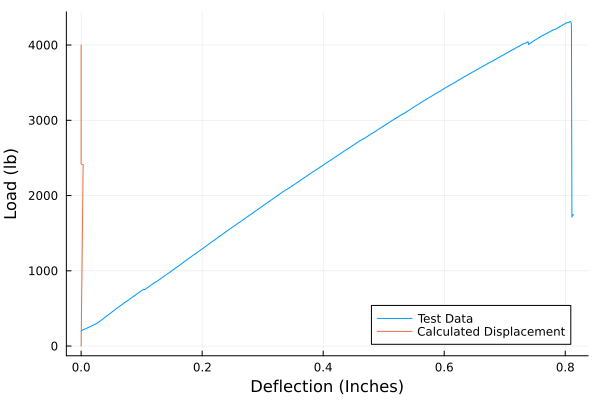

In [27]:
#add our calculated plot
#plot
plt = plot(test_d,test_P, label = "Test Data")
plot!(dis_in, P_lb, label = "Calculated Displacement",
xlabel = "Deflection (Inches)", ylabel = "Load (lb)")